In [9]:
import math
import time
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [10]:
df = pd.read_csv(
    filepath_or_buffer='data.csv',
    sep=',')

vals = df.iloc[:,:].values

In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
df.size

69988820

In [13]:
print('Number of each type')
print(Counter(df['type']))
print('Total number of Fraud')
print(Counter(df['isFraud']))
print('Number of fraud under PAYMENT')
print(Counter(df[df['type'] == 'PAYMENT']['isFraud']))
print('Number of fraud under TRANSFER')
print(Counter(df[df['type'] == 'TRANSFER']['isFraud']))
print('Number of fraud under CASH_OUT')
print(Counter(df[df['type'] == 'CASH_OUT']['isFraud']))
print('Number of fraud under DEBIT')
print(Counter(df[df['type'] == 'DEBIT']['isFraud']))
print('Number of fraud under CASH_IN')
print(Counter(df[df['type'] == 'CASH_IN']['isFraud']))

Number of each type
Counter({'CASH_OUT': 2237500, 'PAYMENT': 2151495, 'CASH_IN': 1399284, 'TRANSFER': 532909, 'DEBIT': 41432})
Total number of Fraud
Counter({0: 6354407, 1: 8213})
Number of fraud under PAYMENT
Counter({0: 2151495})
Number of fraud under TRANSFER
Counter({0: 528812, 1: 4097})
Number of fraud under CASH_OUT
Counter({0: 2233384, 1: 4116})
Number of fraud under DEBIT
Counter({0: 41432})
Number of fraud under CASH_IN
Counter({0: 1399284})


### it can be seen that all fraud action comes from TRANSFER and CASH_OUT, so only actions from these two categories are considered

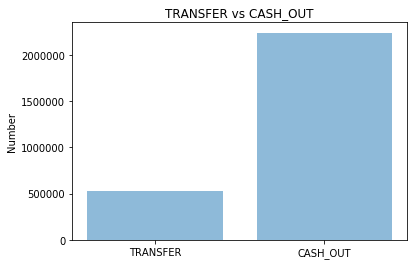

In [14]:

objects = ('TRANSFER', 'CASH_OUT')
y_pos = np.arange(len(objects))
performance = [532909,2237500]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('TRANSFER vs CASH_OUT')

plt.show()

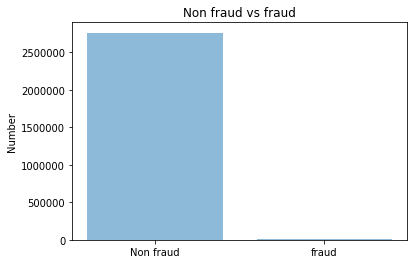

In [15]:
objects = ('Non fraud', 'fraud')
y_pos = np.arange(len(objects))
performance = [2762196,8213]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Non fraud vs fraud')

plt.show()

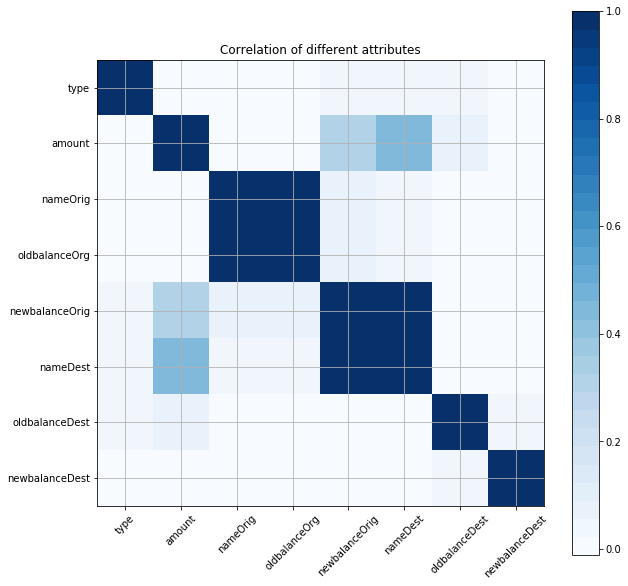

In [16]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('Blues', 30)
cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
ax1.grid(True)
plt.title("Correlation of different attributes")
labels = df.columns.tolist()
ax1.set_xticklabels(labels, rotation=45)
ax1.set_yticklabels(labels)
fig.colorbar(cax)
plt.show()

### From the correlation heatmap, it can be seen that amoung, oldbalanceOrg, nnewbalanceOrig, oldbalanceDest and newbalanceDest have greater correlation to the fraud parameter

### a. using all the attributes to train a KNN model

In [17]:
data = []
for i in vals[1:]:
    if 'C' in i[3] and 'C' in i[6] and (i[1] == 'TRANSFER' or i[1] == 'CASH_OUT'):
        data.append(i)

In [18]:
X = []
y = []
for i in data:
    tmp = []
    tmp.append(i[2])
    tmp.append(i[4])
    tmp.append(i[5])
    tmp.append(i[7])
    tmp.append(i[8])
    X.append(tmp)
    y.append(int(i[9]) or int(i[10]))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
y_pred = classifier.predict(X_test)

### F1 score, auc and cross validation

In [52]:
from sklearn.metrics import f1_score
f1_macro = f1_score(y_test, y_pred, average='macro')
print('f1 using macro is ' , f1_macro)

f1 using macro is  0.8978706263372438


In [53]:
f1_micro = f1_score(y_test, y_pred, average='micro')
print('f1 using micro is ' , f1_micro)

f1 using micro is  0.9988990799195787


In [54]:
f1_wei = f1_score(y_test, y_pred, average='weighted')
print('f1 using weighted is ' , f1_wei)

f1 using weighted is  0.998846465468737


In [55]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print('auc is ' , auc)

auc is  0.8631785296814942


### b. using only oldbalanceOrg and oldbalanceDest for knn model

In [26]:
data1 = []
for i in vals[1:]:
    if 'C' in i[3] and 'C' in i[6] and (i[1] == 'TRANSFER' or i[1] == 'CASH_OUT'):
        data1.append(i)
        
X1 = []
y1 = []
for i in data1:
    tmp = []
    tmp.append(i[2])
    tmp.append(i[4])
    tmp.append(i[7])
    X1.append(tmp)
    y1.append(int(i[9]) or int(i[10]))
    
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.8, random_state=0)

In [27]:
scaler = StandardScaler()
scaler.fit(X_train1)

X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train1, y_train1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
y_pred1 = classifier.predict(X_test1)

### F1 score, auc and cross validation

In [56]:
f1_macro1 = f1_score(y_test1, y_pred1, average='macro')
print('f1 using macro is ' , f1_macro1)

f1 using macro is  0.8481104688504542


In [59]:
f1_micro1 = f1_score(y_test1, y_pred1, average='micro')
print('f1 using micro is ' , f1_micro1)

f1 using micro is  0.9983066585812208


In [60]:
f1_wei1 = f1_score(y_test1, y_pred1, average='weighted')
print('f1 using weighted is ' , f1_wei1)

f1 using weighted is  0.9982564327846667


In [61]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test1, y_pred1)
auc1 = metrics.auc(fpr1, tpr1)
print('auc is ' , auc1)

auc is  0.8286241994056812


In [32]:
from sklearn.model_selection import cross_val_score, cross_validate
score = ['f1_micro']
scores = cross_validate(classifier, X_train1, y_train1, scoring=score, cv=5, return_train_score=True)

In [33]:
scores

{'fit_time': array([0.54815221, 0.61263585, 0.66653991, 0.59838629, 0.82111096]),
 'score_time': array([1.16774774, 1.19263792, 1.23605609, 1.328053  , 1.13271022]),
 'test_f1_micro': array([0.99826741, 0.99831252, 0.99811399, 0.99833057, 0.99810497]),
 'train_f1_micro': array([0.99870506, 0.99869153, 0.99871183, 0.9986825 , 0.9986983 ])}

### c. using only newbalanceOrg and newbalanceDest for knn model

In [35]:
data2 = []
for i in vals[1:]:
    if 'C' in i[3] and 'C' in i[6] and (i[1] == 'TRANSFER' or i[1] == 'CASH_OUT'):
        data2.append(i)
        
X2 = []
y2 = []
for i in data1:
    tmp = []
    tmp.append(i[2])
    tmp.append(i[5])
    tmp.append(i[8])
    X2.append(tmp)
    y2.append(int(i[9]) or int(i[10]))
    
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.8, random_state=0)

In [36]:
scaler = StandardScaler()
scaler.fit(X_train2)

X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train2, y_train2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [37]:
y_pred2 = classifier.predict(X_test2)

### F1 score, auc and cross validation

In [66]:
f1_macro2 = f1_score(y_test2, y_pred2, average='macro')
print('f1 using macro is ' , f1_macro2)

f1 using macro is  0.6845240599676657


In [65]:
f1_micro2 = f1_score(y_test2, y_pred2, average='micro')
print('f1 using micro is ' , f1_micro2)

f1 using micro is  0.9974773589468707


In [63]:
f1_wei2 = f1_score(y_test2, y_pred2, average='weighted')
print('f1 using weighted is ' , f1_wei2)

f1 using weighted is  0.9968752554958896


In [62]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test2, y_pred2)
auc2 = metrics.auc(fpr2, tpr2)
print('auc is ' , auc2)

auc is  0.6250955478152838


In [41]:
score1 = ['f1_micro']
scores1 = cross_validate(classifier, X_train2, y_train2, scoring=score1, cv=5, return_train_score=True)

In [42]:
scores1

{'fit_time': array([263.88533616, 272.19624996, 282.69404483, 259.88544202,
        279.80830193]),
 'score_time': array([2.6450417 , 2.93485618, 2.86685801, 2.93998218, 1.87689209]),
 'test_f1_micro': array([0.99734698, 0.99731086, 0.99741915, 0.99749134, 0.99743719]),
 'train_f1_micro': array([0.99761542, 0.99762896, 0.99763798, 0.99759512, 0.9976267 ])}

In [47]:
from sklearn.metrics import roc_curve, auc
fpr2, recall2, thresholds2 = roc_curve(y_test, y_pred)
auc(fpr2, recall2)

0.8631785296814942